In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as ss
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from contextlib import contextmanager
import joblib
import platform

In [4]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn.utils import resample

from tensorflow.keras.metrics import BinaryAccuracy
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

RANDOM_SEED = 2080
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [5]:
df = pd.read_csv("../icu_train.csv")
df_test = pd.read_csv("../icu_test.csv")
print(df.shape)
df.columns

(73370, 141)


Index(['age', 'bmi', 'elective_surgery', 'gender', 'pre_icu_los_days',
       'apache_post_operative', 'arf_apache', 'bun_apache',
       'creatinine_apache', 'gcs_motor_apache',
       ...
       'apache_2_diagnosis_219.0', 'apache_2_diagnosis_301.0',
       'apache_2_diagnosis_302.0', 'apache_2_diagnosis_303.0',
       'apache_2_diagnosis_304.0', 'apache_2_diagnosis_305.0',
       'apache_2_diagnosis_306.0', 'apache_2_diagnosis_307.0',
       'apache_2_diagnosis_308.0', 'hospital_death'],
      dtype='object', length=141)

In [6]:
if "Unnamed: 0" in df.columns:
    df = df.drop(columns=["Unnamed: 0"])

if "Unnamed: 0" in df_test.columns:
    df_test = df_test.drop(columns=["Unnamed: 0"])

X_train = df.drop(columns=["hospital_death"])
y_train = df["hospital_death"].astype(int)
X_test = df_test.drop(columns=["hospital_death"])
y_test = df_test["hospital_death"].astype(int)

In [9]:
def evaluate(name, y_true, y_prob, threshold = .5):
    y_pred = (y_prob >= threshold).astype(int)

    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1  = f1_score(y_true, y_pred, average='binary')
    f1_w = f1_score(y_true, y_pred, average='weighted')

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"AUROC : {auc:.4f}")
    print(f"Precision : {prec:.4f}")
    print(f"Recall : {rec:.4f}")
    print(f"F1 : {f1:.4f}")
    print(f"F1_weighted : {f1_w:.4f}")
    print("-" * 40)

    return {"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1, "f1_weighted": f1_w}

def plot_metric(results, metric='f1'):
    df = pd.DataFrame(results)
    
    df['run'] = df.groupby('model').cumcount() + 1
    df['label'] = df['model'] + ' #' + df['run'].astype(str)
    
    count = len(df)
    width = max(8, count * 0.4)
    _, ax = plt.subplots(figsize=(width, 6))
    
    ax.bar(df['label'], df[metric])
    ax.set_ylabel(metric.upper() + ' Score')
    ax.set_title(f'{metric.upper()} Score by Model and Run')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

@contextmanager
def safe_parallel_backend():
    system = platform.system()
    is_wsl = 'microsoft' in platform.uname().release.lower()

    if system == "Windows" or is_wsl:
        with joblib.parallel_backend('threading'):
            yield
    else:
        yield

classes = np.unique(y_train)
cw = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weight_dict = dict(zip(classes, cw))
sample_weight_train = np.array([class_weight_dict[y] for y in y_train])

results = []

In [ ]:
 
print("Balanced training set class counts:")
print(y_bal.value_counts())


log_clf_bal = LogisticRegression(
    max_iter=3000,
    penalty="l2",
    solver="lbfgs",
    n_jobs=1,
    random_state=RANDOM_SEED)
log_clf_bal.fit(X_bal, y_bal)

y_pred_bal = log_clf_bal.predict(X_test)
y_prob_lr = log_clf_bal.predict_proba(X_test)[:, 1]
print("=== Downsampled Logistic Regression ===")
print(classification_report(y_test, y_pred_bal, digits=4))

results.append(evaluate("Logistic Regression", y_test, y_pred_bal))

Balanced training set class counts:
hospital_death
0    6332
1    6332
Name: count, dtype: int64
=== Downsampled Logistic Regression ===
              precision    recall  f1-score   support

           0     0.9742    0.8032    0.8805     16760
           1     0.2710    0.7745    0.4015      1583

    accuracy                         0.8007     18343
   macro avg     0.6226    0.7889    0.6410     18343
weighted avg     0.9135    0.8007    0.8391     18343


=== Logistic Regression ===
Accuracy : 0.8007
AUROC : 0.7889
Precision : 0.2710
Recall : 0.7745
F1 : 0.4015
F1_weighted : 0.8391
----------------------------------------


In [7]:
param_dist = {
    'n_estimators': [100,200,400,800],
    'learning_rate': [0.01,0.03,0.1],
    'max_depth': [3,5,7],
    'subsample': [0.6,0.8,1.0],
    'colsample_bytree': [0.6,0.8,1.0],
}

xgb = XGBClassifier(objective='binary:logistic', eval_metric='auc', random_state=42)
search_xgb = RandomizedSearchCV(
    xgb, param_distributions=param_dist,
    n_iter=30, cv=4, scoring='roc_auc',
    random_state=2080, n_jobs=1, verbose=1
)
with safe_parallel_backend():
    search_xgb.fit(X_bal, y_bal)
print("Best XGB params:", search_xgb.best_params_)
xgb_clf = search_xgb.best_estimator_


Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best XGB params: {'subsample': 0.6, 'n_estimators': 400, 'max_depth': 7, 'learning_rate': 0.03, 'colsample_bytree': 1.0}


In [8]:
# xgb_clf = XGBClassifier(
#     n_estimators=800,
#     learning_rate=0.03,
#     max_depth=5,
#     subsample=0.8,
#     colsample_bytree=0.8,
#     scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum(),
#     objective="binary:logistic",
#     eval_metric="auc",
#     random_state=RANDOM_SEED,
#     n_jobs=-1)

xgb_clf.fit(X_bal, y_bal, verbose=False)
y_prob_xgb = xgb_clf.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_clf.predict(X_test)


results.append(evaluate("XGBoost", y_test, y_prob_xgb))


=== XGBoost ===
Accuracy : 0.8069
AUROC : 0.8913
Precision : 0.2838
Recall : 0.8124
F1 : 0.4207
F1_weighted : 0.8441
----------------------------------------


In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical

X_train_np = X_train.to_numpy().astype("float32")
X_test_np  = X_test.to_numpy().astype("float32")

y_train_int = y_train.to_numpy().astype("int32")
y_test_int  = y_test.to_numpy().astype("int32")

y_train_cat = to_categorical(y_train_int, num_classes=2).astype("float32")
y_test_cat  = to_categorical(y_test_int,  num_classes=2).astype("float32")

model_mc = Sequential([
    Dense(512, activation='relu', input_shape=(X_train_np.shape[1],)),
    BatchNormalization(),
    Dropout(0.25),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.25),
    Dense(2, activation="softmax")])

model_mc.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

history_mc = model_mc.fit(
    X_train_np,
    y_train_cat,
    validation_split=0.15,
    epochs=50,
    batch_size=256)

loss, acc, auc_mc = model_mc.evaluate(X_test_np, y_test_cat, verbose=0)
print(f"Test loss: {loss:.4f}, Test acc: {acc:.4f}, Test AUC: {auc_mc:.4f}")

y_prob_mc = model_mc.predict(X_test_np, batch_size=256)
y_pred_mc = y_prob_mc.argmax(axis=1)

print(evaluate("MultiClass MLP", y_test_int, y_prob_mc[:,1]))
print(classification_report(y_test_int, y_pred_mc, digits=4))
print("ROC AUC (class-1):", roc_auc_score(y_test_int, y_prob_mc[:,1]))
results.append(evaluate("MultiClass MLP", y_test_int, y_prob_mc[:,1]))


2025-04-28 14:42:07.924683: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-04-28 14:42:07.925312: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/50
244/244 [==============================] - 5s 13ms/step - loss: 0.4456 - accuracy: 0.8346 - auc: 0.8833 - val_loss: 0.2148 - val_accuracy: 0.9316 - val_auc: 0.9703
Epoch 2/50
244/244 [==============================] - 3s 12ms/step - loss: 0.2458 - accuracy: 0.9176 - auc: 0.9594 - val_loss: 0.1926 - val_accuracy: 0.9329 - val_auc: 0.9765
Epoch 3/50
244/244 [==============================] - 3s 11ms/step - loss: 0.2156 - accuracy: 0.9219 - auc: 0.9703 - val_loss: 0.1869 - val_accuracy: 0.9325 - val_auc: 0.9776
Epoch 4/50
244/244 [==============================] - 3s 12ms/step - loss: 0.2053 - accuracy: 0.9252 - auc: 0.9731 - val_loss: 0.1839 - val_accuracy: 0.9333 - val_auc: 0.9782
Epoch 5/50
244/244 [==============================] - 3s 11ms/step - loss: 0.1989 - accuracy: 0.9262 - auc: 0.9751 - val_loss: 0.1833 - val_accuracy: 0.9329 - val_auc: 0.9782
Epoch 6/50
244/244 [==============================] - 3s 13ms/step - loss: 0.1947 - accuracy: 0.9270 - auc: 0.9762 - val_loss

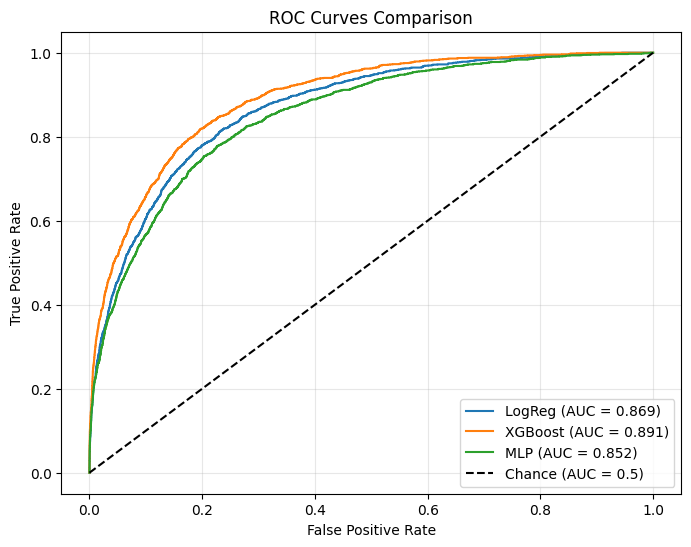

In [10]:
fpr_lr,  tpr_lr,  _ = roc_curve(y_test, y_prob_lr)
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_mlp, tpr_mlp, _ = roc_curve(y_test, y_prob_mc[:,1])

auc_lr  = auc(fpr_lr,  tpr_lr)
auc_xgb = auc(fpr_xgb, tpr_xgb)
auc_mlp = auc(fpr_mlp, tpr_mlp)

plt.figure(figsize=(8, 6))
plt.plot(fpr_lr,  tpr_lr,  label=f'LogReg (AUC = {auc_lr:.3f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {auc_xgb:.3f})')
plt.plot(fpr_mlp, tpr_mlp, label=f'MLP (AUC = {auc_mlp:.3f})')

plt.plot([0, 1], [0, 1], 'k--', label='Chance (AUC = 0.5)')

plt.title('ROC Curves Comparison')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)


/tmp/ipykernel_44234/3597834849.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  prevalence = df_test.groupby(axis)['hospital_death'].mean().loc[counts.index]


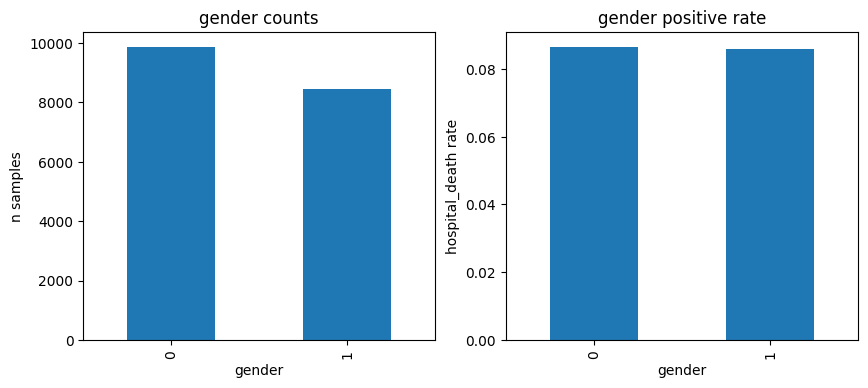

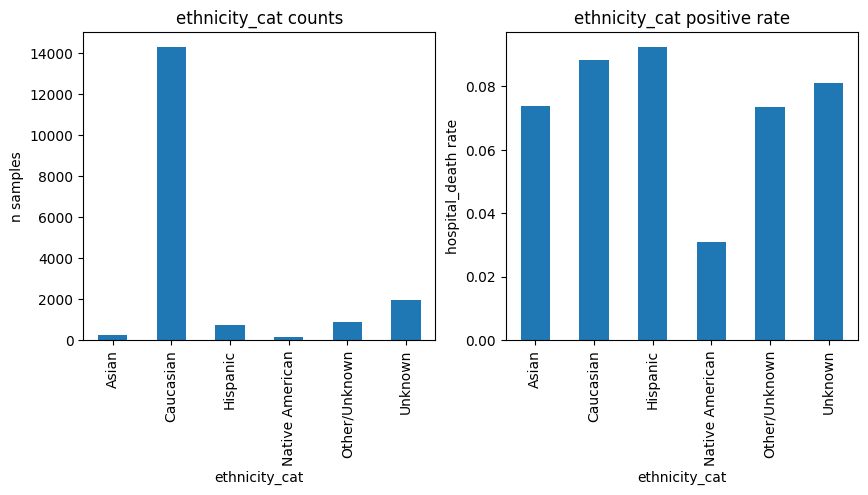

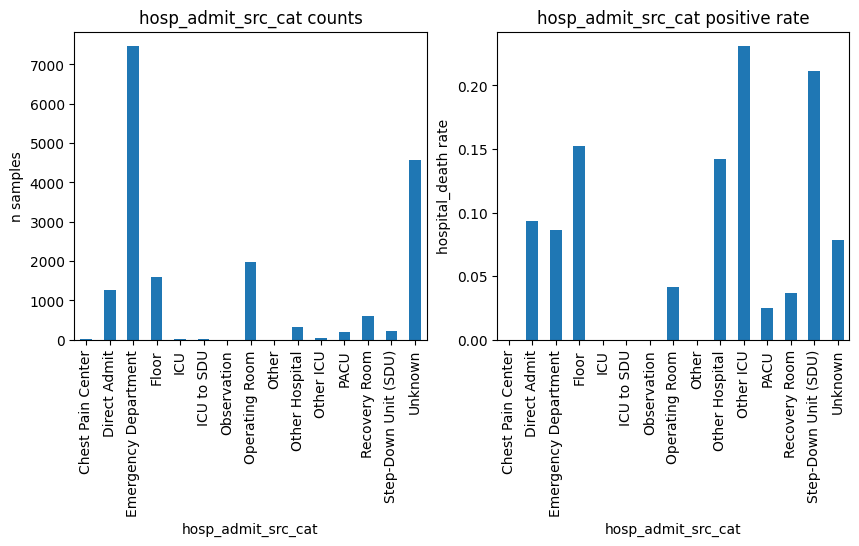

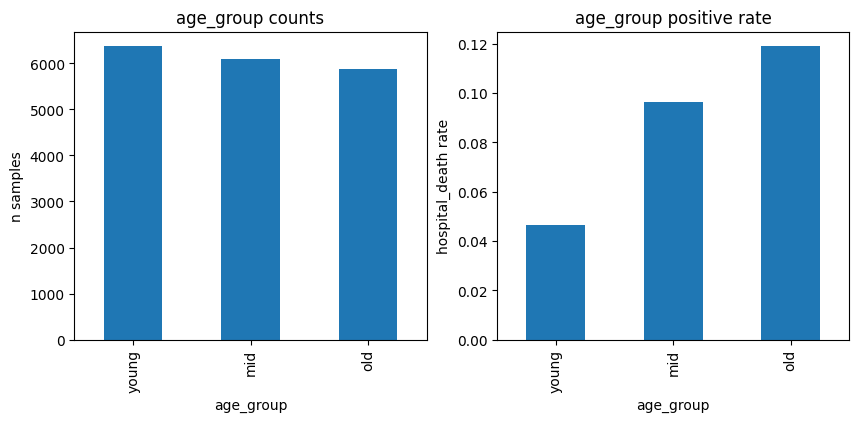

In [11]:
eth_cols = ['ethnicity_Asian', 'ethnicity_Caucasian', 'ethnicity_Hispanic', 'ethnicity_Native American', 'ethnicity_Other/Unknown']

def decode_onehot(df, cols, prefix):
    def pick(row):
        ones = [c for c in cols if row[c] == 1]
        if len(ones) == 1:
            return ones[0].split(prefix,1)[1]
        else:
            return 'Unknown'
    return df.apply(pick, axis=1)

df_test = df_test.copy()
df_test['ethnicity_cat'] = decode_onehot(df_test, eth_cols, 'ethnicity_')

hosp_cols = [c for c in df_test.columns if c.startswith('hospital_admit_source_')]

df_test['hosp_admit_src_cat'] = decode_onehot(df_test, hosp_cols, 'hospital_admit_source_')

df_test['age_group'] = pd.qcut(df_test['age'], q=[0, 0.33, 0.66, 1.0], labels=['young','mid','old'])

demo_axes = {
    'gender' : df_test['gender'].unique(),
    'ethnicity_cat' : df_test['ethnicity_cat'].unique(),
    'hosp_admit_src_cat': df_test['hosp_admit_src_cat'].unique(),
    'age_group' : ['young','mid','old']}

models = [
    ('LogReg', y_pred_bal,  y_prob_lr),
    ('XGBoost', y_pred_xgb, y_prob_xgb),
    ('MLP', y_pred_mc, y_prob_mc[:,1]),]


for axis in ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']:
    counts = df_test[axis].value_counts().sort_index()
    prevalence = df_test.groupby(axis)['hospital_death'].mean().loc[counts.index]
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(10,4))
    counts.plot.bar(ax=ax1); ax1.set_title(f'{axis} counts'); ax1.set_xlabel(axis); ax1.set_ylabel('n samples')
    prevalence.plot.bar(ax=ax2); ax2.set_title(f'{axis} positive rate'); ax2.set_xlabel(axis); ax2.set_ylabel('hospital_death rate')

In [12]:
records = []
for model_name, y_pred, y_prob in models:
    for axis, groups in demo_axes.items():
        for grp in groups:
            mask = df_test[axis] == grp
            if mask.sum() < 30:
                continue
            yt = y_test[mask]
            yp = y_pred[mask]
            yp_prob = y_prob[mask]

            records.append({
                'model' : model_name,
                'demographic': axis,
                'group': grp,
                'n_samples': int(mask.sum()),
                'accuracy': accuracy_score(yt, yp),
                'auc': roc_auc_score(yt, yp_prob) if yt.nunique()>1 else float('nan'),
                'precision': precision_score(yt, yp, zero_division=0),
                'recall': recall_score(yt, yp, zero_division=0),
                'f1': f1_score(yt, yp, zero_division=0)})

df_subgroup = pd.DataFrame(records)

table = df_subgroup.pivot_table(index=['demographic','group'], columns='model', values=['accuracy','auc','f1'], aggfunc='first')

print(table)

                                         accuracy                      \
model                                      LogReg       MLP   XGBoost   
demographic        group                                                
age_group          mid                   0.804134  0.910269  0.794455   
                   old                   0.701617  0.880000  0.725787   
                   young                 0.888889  0.955744  0.893597   
ethnicity_cat      Asian                 0.795082  0.942623  0.799180   
                   Caucasian             0.800349  0.914236  0.806420   
                   Hispanic              0.741497  0.911565  0.776871   
                   Native American       0.820988  0.956790  0.833333   
                   Other/Unknown         0.819800  0.926585  0.843159   
                   Unknown               0.816016  0.922453  0.803852   
gender             0                     0.800627  0.917257  0.812968   
                   1                     0.800875  

72/72 [==============================] - 0s 3ms/step


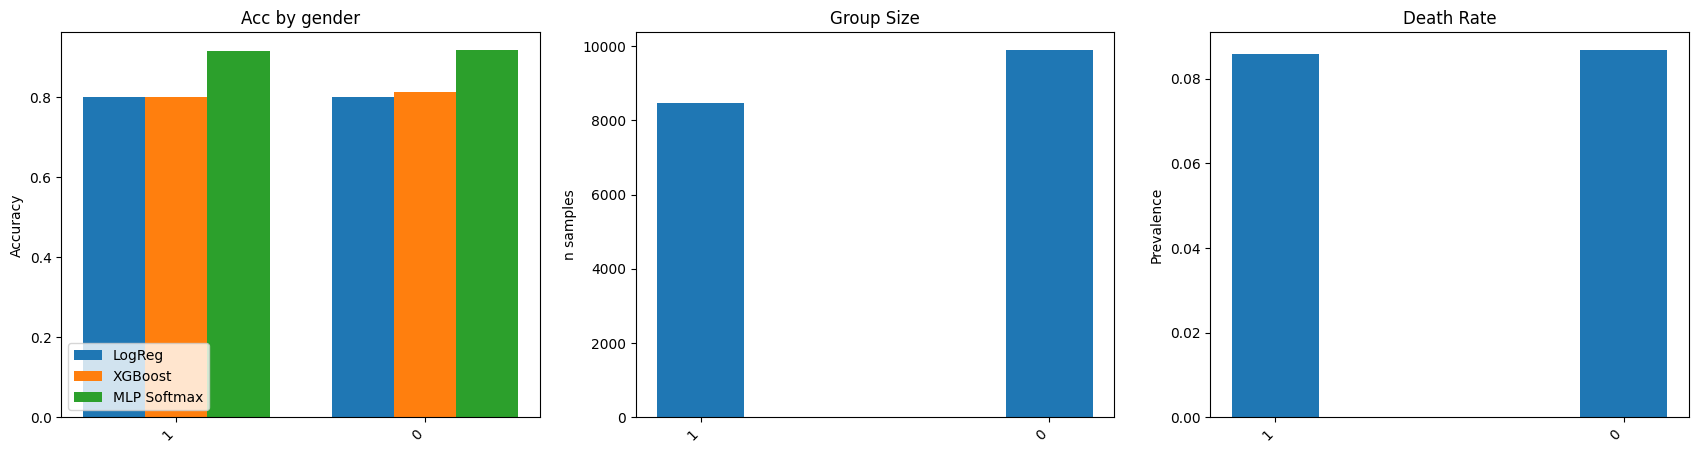

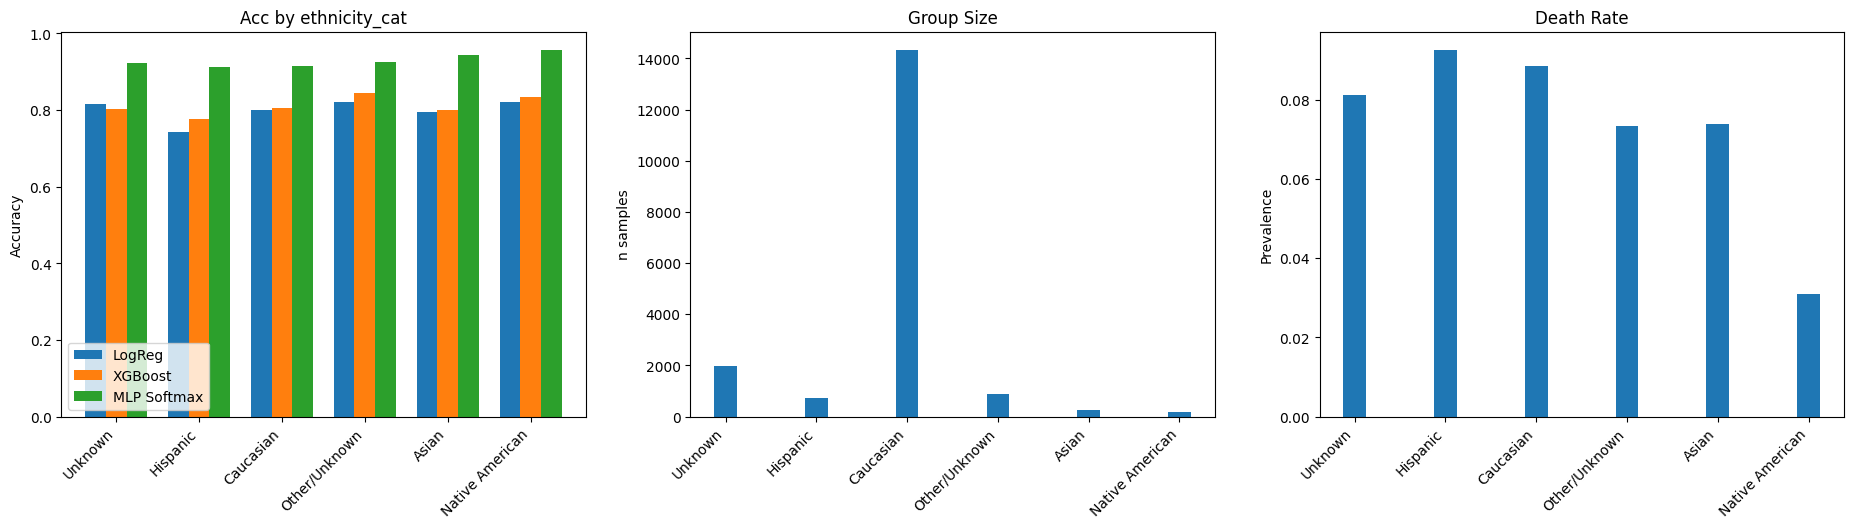

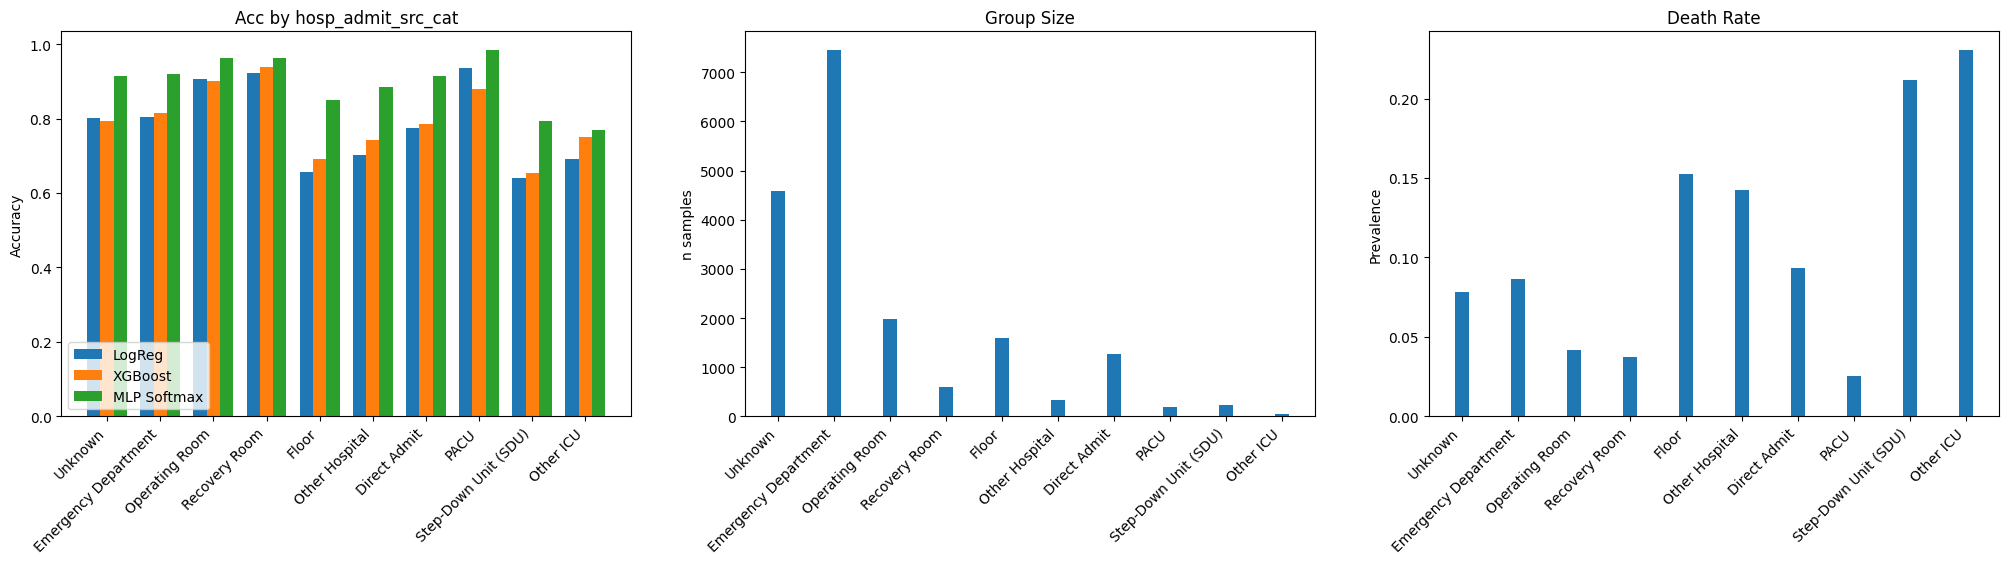

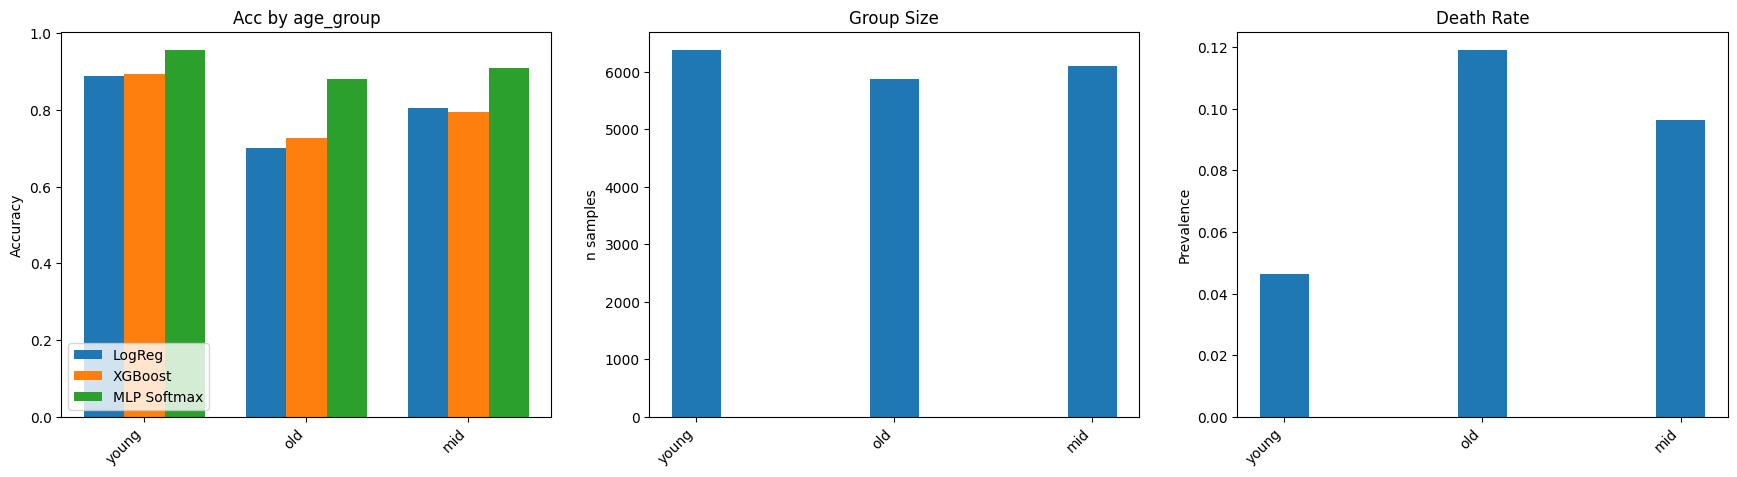

In [13]:
from sklearn.metrics import accuracy_score

y_prob_lr = log_clf_bal.predict_proba(X_test)[:,1]
y_pred_lr = (y_prob_lr  >= 0.5).astype(int)

y_prob_xgb = xgb_clf.predict_proba(X_test)[:,1]
y_pred_xgb = (y_prob_xgb >= 0.5).astype(int)

y_prob_mlp = model_mc.predict(X_test_np, batch_size=256)
y_pred_mlp = y_prob_mlp.argmax(axis=1)

models = [("LogReg", y_pred_lr), ("XGBoost", y_pred_xgb), ("MLP Softmax", y_pred_mlp)]

demographics = ['gender','ethnicity_cat','hosp_admit_src_cat','age_group']

records = []
for name, y_pred in models:
    for axis in demographics:
        for grp in df_test[axis].unique():
            mask = df_test[axis] == grp
            if mask.sum() < 30:
                continue
            ba = accuracy_score(y_test[mask], y_pred[mask])
            records.append({
                'model': name,
                'demographic': axis,
                'group': grp,
                'balanced_accuracy': ba,
                'n_samples': mask.sum(),
                'prevalence': df_test.loc[mask,'hospital_death'].mean()
            })
df_bal = pd.DataFrame(records)

for axis in demographics:
    df_axis = df_bal[df_bal['demographic']==axis]
    groups  = list(df_axis['group'].unique())
    x = np.arange(len(groups))
    width = 0.25

    fig, (ax_ba, ax_n, ax_p) = plt.subplots(1,3, figsize=(len(groups)*0.5+20, 5))
    for i,(name,_) in enumerate(models):
        vals = [df_axis[(df_axis['model']==name)&(df_axis['group']==g)]['balanced_accuracy'].iloc[0]
                for g in groups ]
        ax_ba.bar(x + i*width, vals, width, label=name)
    ax_ba.set_xticks(x + width*(len(models)-1)/2)
    ax_ba.set_xticklabels(groups, rotation=45, ha='right')
    ax_ba.set_title(f'Acc by {axis}')
    ax_ba.set_ylabel('Accuracy')
    ax_ba.legend(loc='lower left')

    counts = [df_axis[df_axis['group']==g]['n_samples'].iloc[0] for g in groups ]
    ax_n.bar(x, counts, width)
    ax_n.set_xticks(x); ax_n.set_xticklabels(groups, rotation=45, ha='right')
    ax_n.set_title('Group Size'); ax_n.set_ylabel('n samples')

    prevs = [df_axis[df_axis['group']==g]['prevalence'].iloc[0] for g in groups ]
    ax_p.bar(x, prevs, width)
    ax_p.set_xticks(x); ax_p.set_xticklabels(groups, rotation=45, ha='right')
    ax_p.set_title('Death Rate'); ax_p.set_ylabel('Prevalence')

In [14]:
log_coefs = pd.Series(log_clf_bal.coef_.ravel(), index=X_train.columns)
top10_log = log_coefs.abs().sort_values(ascending=False).head(10)
print("=== Top 10 Logistic Regression Coefficients (abs) ===")
print(top10_log.to_string(), "\n")

xgb_imp = pd.Series(xgb_clf.feature_importances_, index=X_train.columns)
top10_xgb = xgb_imp.sort_values(ascending=False).head(10)
print("=== Top 10 XGBoost Feature Importances ===")
print(top10_xgb.to_string(), "\n")

=== Top 10 Logistic Regression Coefficients (abs) ===
apache_2_diagnosis_123.0       1.657286
apache_2_diagnosis_208.0       1.435474
icu_admit_source_Other ICU     1.347015
apache_2_diagnosis_217.0       1.063695
apache_2_diagnosis_114.0       0.972177
apache_2_diagnosis_209.0       0.853408
ventilated_apache              0.845599
solid_tumor_with_metastasis    0.810026
apache_2_diagnosis_116.0       0.801637
gcs_unable_apache              0.791241 

=== Top 10 XGBoost Feature Importances ===
apache_4a_hospital_death_prob      0.092708
ventilated_apache                  0.019594
apache_2_diagnosis_114.0           0.013797
d1_spo2_min                        0.013325
d1_sysbp_min                       0.011872
solid_tumor_with_metastasis        0.011375
icu_admit_source_Other Hospital    0.011251
icu_admit_source_Other ICU         0.011184
apache_2_diagnosis_121.0           0.010807
apache_2_diagnosis_203.0           0.010514 



In [15]:
y_prob_mlp = model_mc.predict(X_test_np)
y_prob_mlp1 = y_prob_mlp[:,1]

baseline_auc = roc_auc_score(y_test_int, y_prob_mlp1)

importances = {}
for col in X_test.columns:
    X_perm = X_test.copy()
    X_perm[col] = np.random.permutation(X_perm[col].values)
    X_perm_np = X_perm.to_numpy().astype("float32")
    y_prob_perm = model_mc.predict(X_perm_np)[:, 1]
    perm_auc = roc_auc_score(y_test_int, y_prob_perm)
    importances[col] = baseline_auc - perm_auc

imp = pd.Series(importances).sort_values(ascending=False)
print("Top 10 MLP features (manual permutation importance):")
print(imp.head(10).to_string())

574/574 [==============================] - 1s 1ms/step
Top 10 MLP features (manual permutation importance):
apache_4a_hospital_death_prob    0.030263
age                              0.015281
gcs_motor_apache                 0.011175
d1_heartrate_min                 0.010204
ventilated_apache                0.009611
bun_apache                       0.008917
d1_spo2_min                      0.006860
d1_sysbp_min                     0.006731
d1_sysbp_max                     0.006004
d1_mbp_min                       0.005426


In [16]:
y_train_cat = tf.keras.utils.to_categorical(y_train, num_classes=2)

batch_size = 256
train_ds = (tf.data.Dataset.from_tensor_slices((X_train.values.astype(np.float32), y_train_cat.astype(np.float32))).batch(batch_size).prefetch(1))

norms = []
for X_batch, y_batch in train_ds.take(20):
    for i in range(X_batch.shape[0]):
        x_i = tf.expand_dims(X_batch[i], 0)
        y_i = tf.expand_dims(y_batch[i], 0)
        with tf.GradientTape() as tape:
            preds = model_mc(x_i, training=False)
            loss  = tf.keras.losses.categorical_crossentropy(y_i, preds)
        grads = tape.gradient(loss, model_mc.trainable_variables)
        grad_norm = tf.linalg.global_norm(grads).numpy()
        norms.append(grad_norm)

print("Gradient norm percentiles:", np.percentile(norms, [50,80,90,95,99]))

2025-04-28 14:47:13.233753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [73370,2]
	 [[{{node Placeholder/_1}}]]


Gradient norm percentiles: [6.36020605e-03 2.16022968e-01 1.29660852e+00 3.86724187e+00
 1.34618698e+01]


In [17]:
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

from tensorflow_privacy.privacy.optimizers.dp_optimizer_keras import DPKerasAdamOptimizer

def evaluate(name, y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    prec = precision_score(y_true, y_pred, zero_division=0)
    rec = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)

    print(f"\n=== {name} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"AUROC    : {auc:.4f}")
    print(f"Precision: {prec:.4f}")
    print(f"Recall   : {rec:.4f}")
    print(f"F1 Score : {f1:.4f}")
    print("-" * 40)

    return {"model": name, "acc": acc, "auc": auc, "prec": prec, "rec": rec, "f1": f1}


def get_noise_multiplier(target_epsilon):
    """ Rough mapping: higher epsilon → lower noise. """
    noise_multiplier = max(0.5, 2.0 / target_epsilon)
    return noise_multiplier


def train_and_evaluate_dp_models(target_epsilon, X_train, y_train, X_test, y_test, RANDOM_SEED=42):
    results = []

    X_train_np = X_train.to_numpy().astype("float32")
    X_test_np  = X_test.to_numpy().astype("float32")
    y_train_np = y_train.to_numpy().astype("int32")
    y_test_np  = y_test.to_numpy().astype("int32")
    y_train_cat = tf.keras.utils.to_categorical(y_train_np, num_classes=2).astype("float32")

    row_norms_train = np.linalg.norm(X_train_np, axis=1)
    X_train_clipped = X_train_np / np.maximum(1.0, row_norms_train).reshape(-1, 1)
    
    row_norms_test = np.linalg.norm(X_test_np, axis=1)
    X_test_clipped = X_test_np / np.maximum(1.0, row_norms_test).reshape(-1, 1)

    base_clf = LogisticRegression(
        penalty='l2',
        solver='lbfgs',
        C=1.0,
        max_iter=3000,
        random_state=RANDOM_SEED)
    base_clf.fit(X_train_clipped, y_train_np)

    sensitivity = 2.0 / (X_train_clipped.shape[0] * 1.0)
    delta = 1e-5

    sigma = sensitivity * np.sqrt(2 * np.log(1.25 / delta)) / target_epsilon
    print(f"LogReg Output Perturbation = {sigma:.6f}")

    base_clf.coef_ += np.random.normal(0, sigma, size=base_clf.coef_.shape)
    base_clf.intercept_ += np.random.normal(0, sigma, size=base_clf.intercept_.shape)

    y_prob_dp_logreg = base_clf.predict_proba(X_test_clipped)[:, 1]
    results.append(evaluate(f"DP Logistic ε={target_epsilon:.2f}", y_test_np, y_prob_dp_logreg))

    noise_multiplier = get_noise_multiplier(target_epsilon)
    batch_size = 256
    epochs = 25

    model_dp = Sequential([
        Dense(512, activation='relu', input_shape=(X_train_np.shape[1],)),
        BatchNormalization(),
        Dropout(0.25),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.25),
        Dense(2, activation="softmax")])

    optimizer = DPKerasAdamOptimizer(
        l2_norm_clip=np.percentile(np.linalg.norm(X_train_np, axis=1), 80),
        noise_multiplier=noise_multiplier,
        num_microbatches=1,
        learning_rate=1e-3)

    model_dp.compile( optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.AUC(name="auc")])

    model_dp.fit(X_train_np, y_train_cat, validation_split=0.15, epochs=epochs, batch_size=batch_size,verbose=2)

    dp_y_prob_mlp = model_dp.predict(X_test_np, batch_size=batch_size)[:, 1]
    results.append(evaluate(f"DP MLP ε={target_epsilon:.2f}", y_test_np, dp_y_prob_mlp))

    return results

def sweep_epsilons(epsilon_list, X_train, y_train, X_test, y_test):
    all_results = []

    for eps in epsilon_list:
        print(f"\n====== Running for ε = {eps} ======")
        results = train_and_evaluate_dp_models(eps, X_train, y_train, X_test, y_test)
        all_results.extend(results)
    return all_results



====== Running for ε = 0.01 ======
LogReg Output Perturbation = 0.076513

=== DP Logistic ε=0.01 ===
Accuracy : 0.7866
AUROC    : 0.8658
Precision: 0.2581
Recall   : 0.7858
F1 Score : 0.3886
----------------------------------------
Epoch 1/25
43/43 - 5s - loss: 1.2284 - accuracy: 0.4893 - auc: 0.4816 - val_loss: 0.7254 - val_accuracy: 0.4579 - val_auc: 0.4432 - 5s/epoch - 119ms/step
Epoch 2/25
43/43 - 1s - loss: 1.2299 - accuracy: 0.4868 - auc: 0.4806 - val_loss: 0.7432 - val_accuracy: 0.4568 - val_auc: 0.4367 - 581ms/epoch - 14ms/step
Epoch 3/25
43/43 - 1s - loss: 1.2451 - accuracy: 0.4889 - auc: 0.4844 - val_loss: 0.7500 - val_accuracy: 0.4768 - val_auc: 0.4659 - 574ms/epoch - 13ms/step
Epoch 4/25
43/43 - 1s - loss: 1.2360 - accuracy: 0.4920 - auc: 0.4858 - val_loss: 0.7746 - val_accuracy: 0.4868 - val_auc: 0.4752 - 559ms/epoch - 13ms/step
Epoch 5/25
43/43 - 1s - loss: 1.2367 - accuracy: 0.4921 - auc: 0.4879 - val_loss: 0.8066 - val_accuracy: 0.4937 - val_auc: 0.4754 - 518ms/epoch -

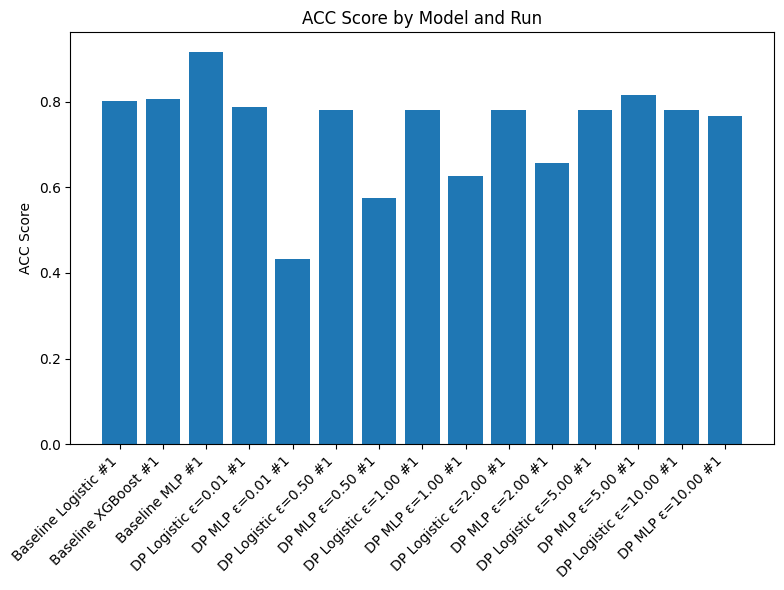

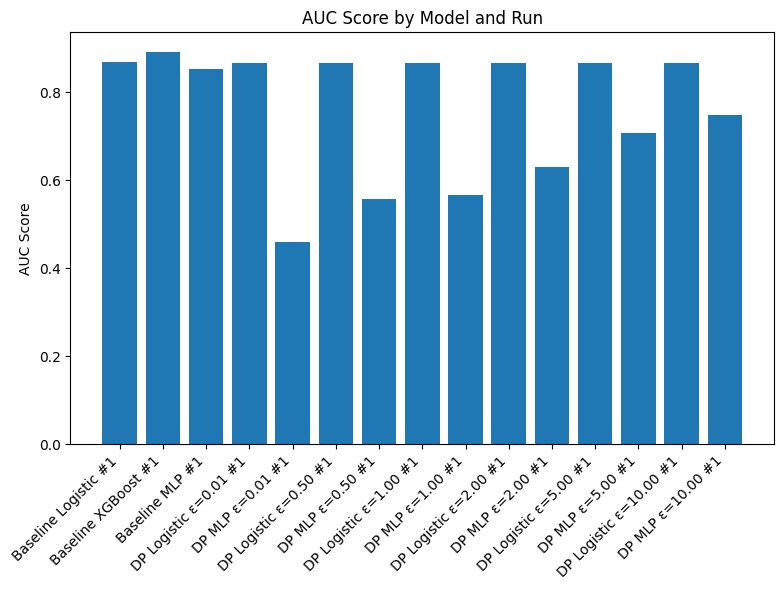

: 

In [ ]:
epsilon_list = [.01, 0.5, 1.0, 2.0, 5.0, 10.0]

all_dp_results = sweep_epsilons(epsilon_list, X_bal, y_bal, X_test, y_test)

baseline_results = []
baseline_results.append(evaluate("Baseline Logistic", y_test, y_prob_lr))
baseline_results.append(evaluate("Baseline XGBoost", y_test, y_prob_xgb))
baseline_results.append(evaluate("Baseline MLP", y_test, y_prob_mlp[:,1]))

final_results = baseline_results + all_dp_results

plot_metric(final_results, metric='acc')
plot_metric(final_results, metric='auc')


In [17]:
import dp_xgboost
final_results = []
def compute_dp_per_tree(target_total_epsilon, n_trees, subsample):
    return np.log(1 + (np.exp(target_total_epsilon / n_trees) - 1) / subsample)

X_train_np = X_train.to_numpy().astype(np.float32)
X_train_np = X_train_np[:5000]
X_test_np = X_test.to_numpy().astype(np.float32)
y_train_np = y_train.to_numpy()[:5000]
y_test_np = y_test.to_numpy()

feature_min = np.min(X_train_np, axis=0).tolist()
feature_max = np.max(X_train_np, axis=0).tolist()

dtrain = dp_xgboost.DMatrix(
    X_train_np, 
    label=y_train_np, 
    feature_min=feature_min,
    feature_max=feature_max
)

dtest = dp_xgboost.DMatrix(
    X_test_np,
    feature_min=feature_min,  # Use training bounds
    feature_max=feature_max
)
fixed_params = {
    "objective": "binary:logistic",
    'tree_method':'approxDP',
    "eval_metric": "auc",
    "learning_rate": 0.03,
    "max_depth": 4,
    "subsample": 0.6,
    "colsample_bytree": 1.0,
    "verbosity": 1,
    # "n_estimators": 400,  # Commented out - not used by dp_xgboost
    # "dp": True,
    # "grad_clip": 1.0,      # Commented out - not used by dp_xgboost
    # "delta": 1e-5,         # Commented out - not used by dp_xgboost
}

n_trees = 200
subsample = 0.4

target_epsilons =[.1, 0.5, 1.0, 2.0, 5.0, 10.0, 20, 50, 100]

for target_total_epsilon in target_epsilons:
    dp_per_tree = compute_dp_per_tree(target_total_epsilon, n_trees=n_trees, subsample=subsample)

    param_dp = fixed_params.copy()
    param_dp.update({
        "dp_epsilon_per_tree": dp_per_tree,
        "max_depth": 5,
    })

    print(f"\nTraining DP-XGBoost with total epsilon ≈ {target_total_epsilon} (per-tree epsilon {dp_per_tree:.4f})")

    bst_dp = dp_xgboost.train(param_dp, dtrain, num_boost_round=n_trees, evals=[(dtrain, 'train')], verbose_eval=False)
    
    y_prob_dp = bst_dp.predict(dtest)
    final_results.append(evaluate(f"DP-XGB epsilon={target_total_epsilon}", y_test_np, y_prob_dp))



Training DP-XGBoost with total epsilon ≈ 0.1 (per-tree epsilon 0.0012)


/home/user/anaconda3/envs/dp-env2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== DP-XGB epsilon=0.1 ===
Accuracy : 0.9137
AUROC : 0.5000
Precision : 0.0000
Recall : 0.0000
F1 : 0.0000
F1_weighted : 0.8725
----------------------------------------

Training DP-XGBoost with total epsilon ≈ 0.5 (per-tree epsilon 0.0062)

=== DP-XGB epsilon=0.5 ===
Accuracy : 0.0863
AUROC : 0.5000
Precision : 0.0863
Recall : 1.0000
F1 : 0.1589
F1_weighted : 0.0137
----------------------------------------

Training DP-XGBoost with total epsilon ≈ 1.0 (per-tree epsilon 0.0125)

=== DP-XGB epsilon=1.0 ===
Accuracy : 0.6597
AUROC : 0.5433
Precision : 0.1021
Recall : 0.3778
F1 : 0.1608
F1_weighted : 0.7325
----------------------------------------

Training DP-XGBoost with total epsilon ≈ 2.0 (per-tree epsilon 0.0248)

=== DP-XGB epsilon=2.0 ===
Accuracy : 0.0863
AUROC : 0.5000
Precision : 0.0863
Recall : 1.0000
F1 : 0.1589
F1_weighted : 0.0137
----------------------------------------

Training DP-XGBoost with total epsilon ≈ 5.0 (per-tree epsilon 0.0614)

=== DP-XGB epsilon=5.0 ===
Accu

/home/user/anaconda3/envs/dp-env2/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



=== DP-XGB epsilon=50 ===
Accuracy : 0.9137
AUROC : 0.7195
Precision : 0.0000
Recall : 0.0000
F1 : 0.0000
F1_weighted : 0.8725
----------------------------------------

Training DP-XGBoost with total epsilon ≈ 100 (per-tree epsilon 0.9639)

=== DP-XGB epsilon=100 ===
Accuracy : 0.0863
AUROC : 0.6279
Precision : 0.0863
Recall : 1.0000
F1 : 0.1589
F1_weighted : 0.0137
----------------------------------------


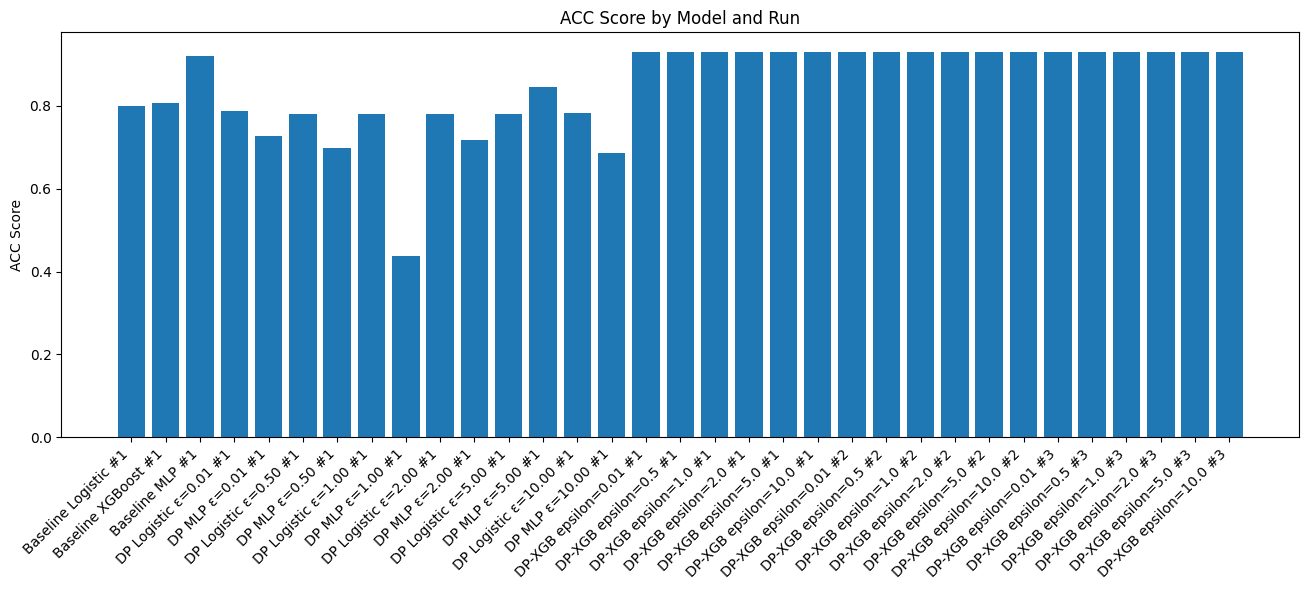

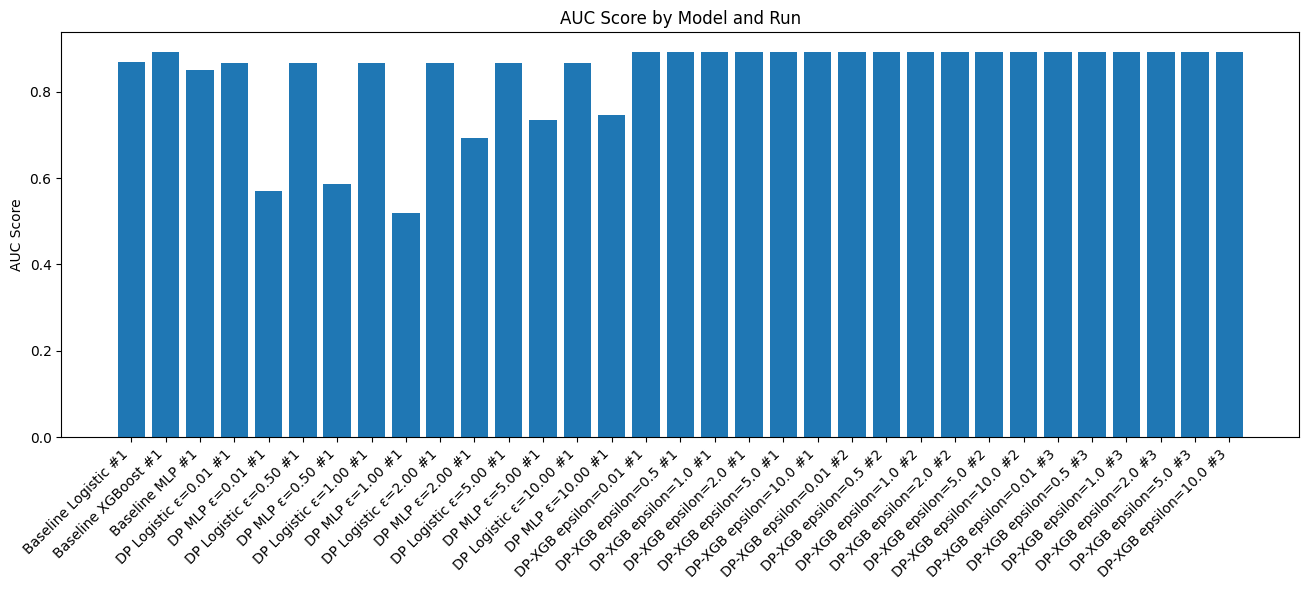

In [ ]:
plot_metric(final_results, metric='acc')
plot_metric(final_results, metric='auc')

In [11]:
print(np.mean(y_prob_dp), np.std(y_prob_dp))
print(np.min(y_prob_dp), np.max(y_prob_dp))

0.2950002 0.012770601
0.2818802 0.38337362
